In [110]:
using JuMP, JuMPeR, Gurobi, Random, StatsBase, Distributions, LinearAlgebra, DataFrames, Plots, Distances, StatsPlots, Statistics

# Process for generating synthetic data

Our supply and demand models time-dependent (can also be product dependent) are given by:
- Supply: $S_{t} = s_{t}p_{t} $ 
- Demand: $D_{t} = \alpha_{t} + (\beta_{t} +\sigma_{t}z_{t})*p_{t}$

And the model which we are trying to maximize (profit) given that supply is greater than demand is given by:
$$\pi(p, z) = \sum_{t=1}^{T} D_{t}p_{t} - c_{t}D_{t} - \delta_{t}v_{t}$$ 

In the above we have
- Decision variables: $p_{t}$ (price at time $t$)
- Uncertain variables: $z_{t}$ (perturbation on the supply) 

The data is given by:
- $\alpha_{t}$: price-insensitive demand at time $t$
- $\beta_{t}$: slope of demand curve at time $t$ 
- $s_{t}$: slope of supply curve at time $t$ 
- $c_{t}$: cost (to the company) of a ride at time $t$, where the wage changes throughout the day
- $\delta_{t}$: the cost of unfulfilled drivers at time $t$ (to keep your drivers engaged)



$\beta_{t} \sim N(B_{t}/100,B_{t}/1000) $ 

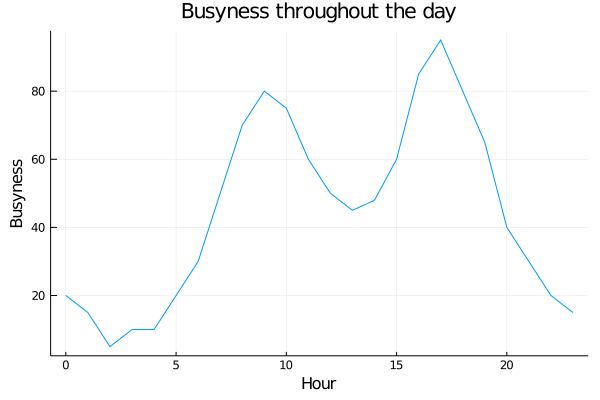

In [2]:
busyness_t = [20,15,5,10,10,20,30,50,70,80,75,60,50,45,48,60,85,95,80,65,40,30,20,15] # latent metric of busyness throughout the day from 0 to 100, starting at 00:00 (12 AM)
n_periods = length(busyness_t)
t = [i for i in range(0,stop =n_periods-1)]
plot(t,busyness_t,title="Busyness throughout the day", xlabel ="Hour",ylabel = "Busyness" , legend = false)

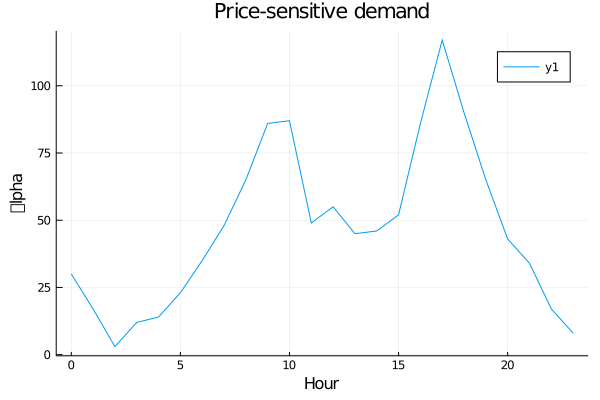

In [3]:
Random.seed!(MersenneTwister(15094)); # we simulate data for 24 hours (hourly timestep)
α = [rand(Poisson(x)) for x in busyness_t]
plot(t,α,title="Price-sensitive demand", xlabel ="Hour",ylabel = "\alpha" )

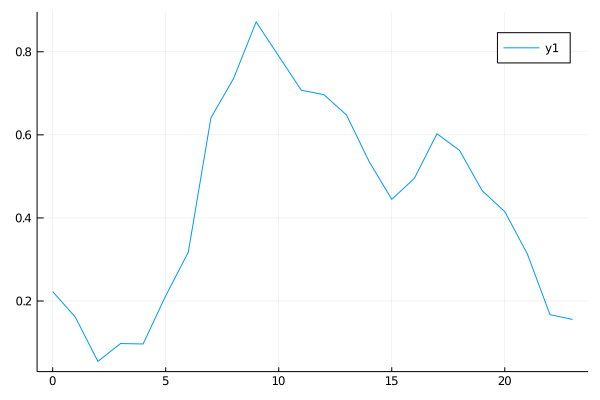

In [4]:

"""
Demand β ∈ [0,10]:
- Smaller β means that consumers are price insensitive (you change price, they don't change quantity of demand)
- Opposite for larger β
- Therefore expect slope to roughly follow busyness because at late hours, people will pay whatever price for a ride home
- In the early hours with lots of drivers, they can afford to take the subway/bus/other transportation
- The difference is that there is more sensitivity in the morning and less at night (if you drove to work, you drive back)
"""
β_t = [20,15,5,10,10,20,30,60,80,90,75,70,70,60,50,50,45,55,60,45,40,30,20,15]
β = [rand(Normal(x/100, x/1000)) for x in β_t]
θ=β/10
plot(t,β)

In [5]:
# plot actual demand throughout the day for different fixed price policies 
prices = [10,20,30,40,60,80,100]
D = zeros(n_periods,length(prices))
for i in range(1, stop = length(prices))
    p = prices[i]
    demand_t = [α[t]-β[t]*p for t in range(1,stop=n_periods)]
    demand_t = [if d>=0 d else 0 end for d in demand_t] # demand can never be negative
    D[:,i] = demand_t
end

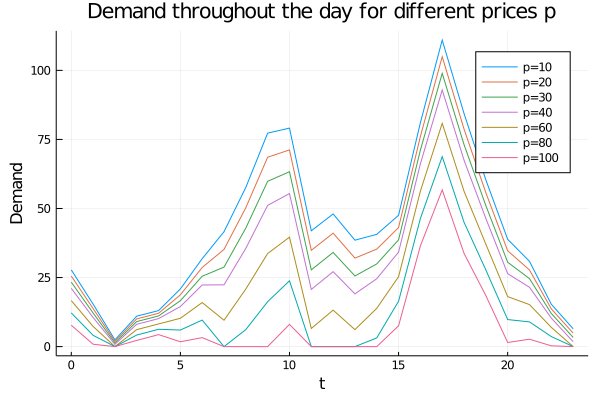

In [6]:
plot(t,D, label = ["p=10" "p=20" "p=30" "p=40" "p=60" "p=80" "p=100"],xlabel = "t", ylabel ="Demand", title="Demand throughout the day for different prices p")

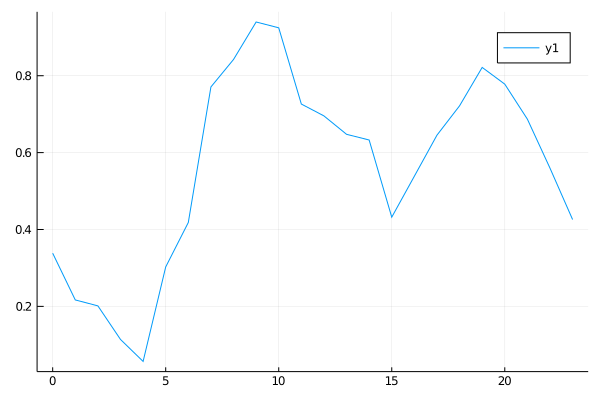

In [7]:
"""
Supply
- When simulating supply slope, we consider the number of active drivers at any time. 
- This is also generally correlated with business
- The only difference is that drivers are more active throughout the evening as well 
"""

s_t = [30,20,20,10,5,30,50,80,90,95,85,75,70,70,65,50,50,55,70,80,75,65,55,45]
#s_t=α.*2.5
s = [rand(Normal(x/100, x/1000)) for x in s_t] 
plot(t,s)


In [8]:
"""
Constants 
- c_t: wages for drivers as a percentage, we can assume that we pay a relatively stable proportion and a little bit more at peak hours  
- δ_t: driver keeping costs, generally higher in the day and lower at night
"""

c = [0.7,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.7,0.7,0.8,0.8,0.7,0.6,0.6,0.8,0.7,0.6,0.6,0.6,0.6,0.7,0.7];
δ = [ 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];

# Solve the nominal problem

$$\pi(p, z) = \sum_{t=1}^{T} D_{t}p_{t} - c_{t}D_{t} + \delta_{t}v_{t}$$ 

In [9]:
#This comes from: rides*p-rides*salary=rides*(p-salary)=rides*(p-c*p)=rides*p(1-c) 
r=-c.+1
;

In [10]:
m = Model(solver = GurobiSolver(OutputFlag=0))
@variable(m, p[1:n_periods] >= 0)
@variable(m, τ)

@constraint(m,
    sum(p[t]*p[t]*r[t]*β[t]+δ[t]*p[t]*β[t]-p[t]*(r[t]*α[t]-δ[t]*s[t])-δ[t]*α[t] for t=1:n_periods)+τ<=0)
@constraint(m, [t=1:n_periods], s[t]*p[t]>=α[t]-β[t]*p[t])

@variable(m, p_abs[2:n_periods] >= 0)
@constraint(m, [t=2:n_periods], p_abs[t] >= p[t] - p[t-1]) 
@constraint(m, [t=2:n_periods], p_abs[t] >= -(p[t] - p[t-1])) 
@constraint(m, [t=2:n_periods], p_abs[t] <= 10) # price constraints

@objective(m, Max, τ);
solve(m)
getobjectivevalue(m)

Academic license - for non-commercial use only


9523.078325109956

In [11]:
p_nominal = getvalue.(p);

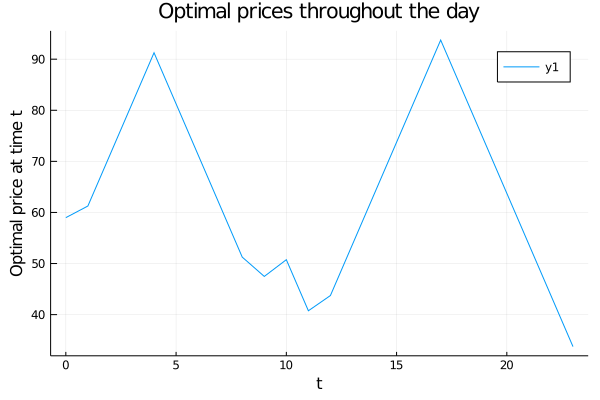

In [12]:
plot(t,getvalue.(p), xlabel = "t", ylabel="Optimal price at time t", title = "Optimal prices throughout the day")

[58.9845, 61.2602, 71.2602, 81.2602, 91.2602, 81.2602, 71.2602, 61.2602, 51.2602, 47.4756, 50.7542, 40.7542, 43.7415, 53.7415, 63.7415, 73.7415, 83.7415, 93.7415, 83.7415, 73.7415, 63.7415, 53.7415, 43.7415, 33.7415]


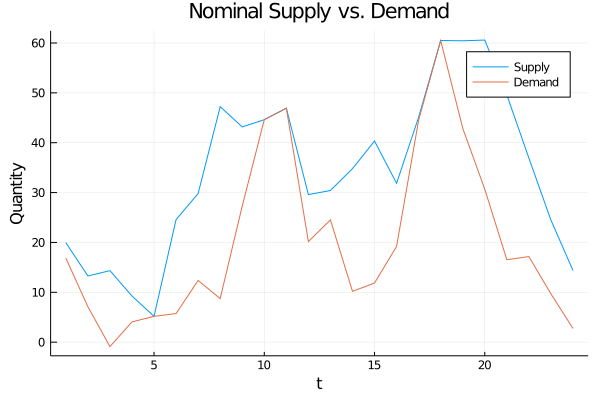

In [13]:
pval=JuMP.getvalue(p);
println(pval)
plot(s.*pval, label="Supply", xlabel = "t", ylabel = "Quantity", title = "Nominal Supply vs. Demand")
plot!(α.-pval.*β, label="Demand")

# Simulate uncertainty set 

When simulating, note that there is a difference between defining the robustness SET and the respective probability DISTRIBUTION. The set is only defined by the boundaries (ellipsoidal, box, budget) while the distribution defines which points in that set are more likely to draw. 

For our purposes, I'll just be doing rejection sampling using a uniform/gaussian distribution, so all uncertainties are centered in the respective sets. 

In [14]:
size(D)

(24, 7)

In [15]:
# box
function generate_z_box(l,n,p)
    """
    Inputs:
    l: the shape of the box 
    n: number of samples
    p: dimension of samples
    
    Returns:
    n x p Matrix of samples 
    """
    return rand(Uniform(-l/2,l/2),n,p)
#     return rand(Uniform(0,l),n,p)
end

# polyhedron
#z = generate_z_poly(D,d,,1,24)
function generate_z_poly(D,d,n,p)
    """
    All points fall into the polyhedron 
    """
    #n_samples = 1
    v = zeros(p)
    max_iter=100000
    iter=1
    dims=size(d)[1]
    c=0
    v_copy=v
    
    t=1
    while t<p+1
        v_copy[t]=rand(Uniform(0,1))
        if sum(D*v_copy .<= d)==dims
           v=v_copy
            t+=1
        end
        c+=1
        if c>1000000
            break
        end
    end
    
    return v
end    
function generate_z_budget(ρ, γ, n, p)
    """
    At most γ (integer) elements are ρ away from their nominal values 
    """
    n_samples = 1
    c = 0
    v = zeros(n,p)
        
    while n_samples < n+1
        x = rand(Uniform(-ρ,ρ),p)
#         print(x)
        if (norm(x,Inf) <= ρ) & (norm(x,1) <= γ)
            v[n_samples,:] = x
            n_samples += 1
        end
        c += 1
        if c >= 100000
            break
        end
    end
    return v
end
    
    

    

generate_z_budget (generic function with 1 method)

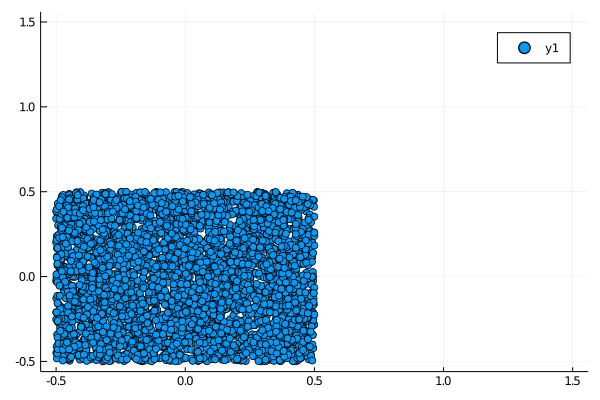

In [16]:
z = generate_z_box(1,4000,2)
scatter(z[:,1], z[:,2], xlim=[-0.5,1.5], ylim=[-0.5,1.5])

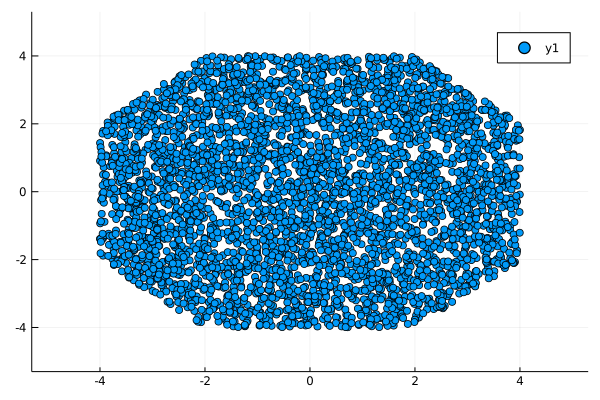

In [17]:
z = generate_z_budget(4,6,4000,2)
scatter(z[:,1], z[:,2], xlim=[-5,5], ylim=[-5,5])

# Next up: Set up robust problem and test profits between robust vs. nominal prices solved above

We are going to solve the robust problems for the following levels of confidences! 

In [18]:
unc_range=[75, 85, 90,95, 97, 99]./100
ϵ=-unc_range.+1
;

### Robust Problem with Box Uncertainty Set

The $\rho$ in the box (and budget) uncertainty set is 1. This is to use the Theorem 3.2

In [19]:
function optimize_box(ρ)
    m = Model(solver = GurobiSolver(OutputFlag=1))
    @variable(m, p[1:n_periods] >= 0)
    @variable(m, v[1:n_periods]>=0) #it will never be negative
    @variable(m, τ)
    @variable(m, p_abs[2:n_periods] >= 0)
    @constraint(m, [t=2:n_periods], p_abs[t] >= p[t] - p[t-1]) 
    @constraint(m, [t=2:n_periods], p_abs[t] >= -(p[t] - p[t-1])) 
    @constraint(m, [t=2:n_periods], p_abs[t] <= 10) # price constraints

    @constraint(m,
        sum(p[t]*p[t]*r[t]*β[t]+δ[t]*p[t]*β[t]-p[t]*(r[t]*α[t]-δ[t]*s[t])-δ[t]*α[t] for t=1:n_periods)+τ+
        ρ*sum(v)<=0)

    @constraint(m, [t=1:n_periods], θ[t]*r[t]*p[t]*p[t]+θ[t]*δ[t]*p[t]<=v[t])


    #robust counterpart
    @constraint(m, [t=1:n_periods], -(s[t]+β[t])*p[t]+α[t]+ρ*p[t]*θ[t]<=0)
    
    #Price constraints
    @variable(m, p_abs[2:n_periods] >= 0)
    @constraint(m, [t=2:n_periods], p_abs[t] >= p[t] - p[t-1])
    @constraint(m, [t=2:n_periods], p_abs[t] >= -(p[t] - p[t-1]))
    @constraint(m, [t=2:n_periods], p_abs[t] <= 10) # price constraints
    
    @objective(m, Max, τ);
    
    solve(m)
    
    IJulia.clear_output()
    
    pval=JuMP.getvalue(p);
    obj_func=JuMP.getobjectivevalue(m)
    return pval, obj_func
end

optimize_box (generic function with 1 method)

In [20]:
ρ=0;
pval, obj_func=optimize_box(ρ);
obj_func


9523.078323567664

In [21]:
ρ=1;
pval, obj_func=optimize_box(ρ);
obj_func


6932.348443933548

In [22]:
print(pval)

[57.3941, 67.3941, 77.3941, 87.3941, 97.3941, 87.3941, 77.3941, 67.3941, 57.3941, 49.8757, 53.2049, 43.2049, 48.4981, 58.4981, 68.4981, 78.4981, 88.4981, 98.4981, 88.4981, 78.4981, 68.4981, 58.4981, 48.4981, 38.4981]

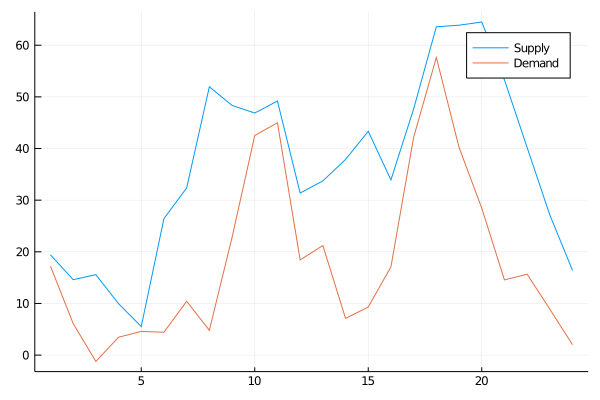

In [23]:
plot(s.*pval, label="Supply")
plot!(α.-pval.*(β), label="Demand")

### Robust Problem with Budget Uncertainty Set

In [24]:
ρ=1
Γ_range= sqrt.(2*log.(1 ./ϵ))*sqrt(n_periods);

In [25]:
function optimize_budget(ρ, Γ)
    m = Model(solver = GurobiSolver(OutputFlag=1))
    @variable(m, p[1:n_periods] >= 0)
    @variable(m, v[1:n_periods]>=0) #it will never be negative
    @variable(m, τ)
    @variable(m, y[1:n_periods])
    @variable(m, y_abs[1:n_periods]>=0)
    @variable(m, inf_norm)
    


    @constraint(m,
        sum(p[t]*p[t]*r[t]*β[t]+δ[t]*p[t]*β[t]-p[t]*(r[t]*α[t]-δ[t]*s[t])-δ[t]*α[t] for t=1:n_periods)+τ+
        ρ*sum(y_abs)+Γ*inf_norm<=0)
    
    #These are some auxiliary constraints to find the conjugate of v|Z. This involves calculating the inf
    #norm of v-y
    @constraint(m, [t=1:n_periods],v[t]-y[t]<=inf_norm)
    @constraint(m, [t=1:n_periods],-v[t]+y[t]<=inf_norm)
    
    @constraint(m, [t=1:n_periods], y[t]<=y_abs[t])
    @constraint(m, [t=1:n_periods], -y[t]<=y_abs[t])

    @constraint(m, [t=1:n_periods], θ[t]*r[t]*p[t]*p[t]+δ[t]*θ[t]*p[t]<=v[t])


    #robust counterpart of the supply>=demand constraint
    @variable(m, y2[1:n_periods])
    @variable(m, y2_abs[1:n_periods]>=0)
    @variable(m, inf_norm2[1:n_periods])
    @constraint(m, [t=1:n_periods], -(s[t]+β[t])*p[t]+α[t]+
        ρ*y2_abs[t]+Γ*inf_norm2[t]<=0)#ρ*p[t]*θ[t]<=0)
    @constraint(m, [t=1:n_periods], y2[t]<=y2_abs[t])
    @constraint(m, [t=1:n_periods], -y2[t]<=y2_abs[t])
    
    @constraint(m, [t=1:n_periods], -θ[t]*p[t]-y2[t]<=inf_norm2[t])
    @constraint(m, [t=1:n_periods], +θ[t]*p[t]+y2[t]<=inf_norm2[t])
    
    
    @variable(m, p_abs[2:n_periods] >= 0)
    @constraint(m, [t=2:n_periods], p_abs[t] >= p[t] - p[t-1])
    @constraint(m, [t=2:n_periods], p_abs[t] >= -(p[t] - p[t-1]))
    @constraint(m, [t=2:n_periods], p_abs[t] <= 10) # price constraints
    #Price constraints
    @variable(m, p_abs[2:n_periods] >= 0)
    @constraint(m, [t=2:n_periods], p_abs[t] >= p[t] - p[t-1])
    @constraint(m, [t=2:n_periods], p_abs[t] >= -(p[t] - p[t-1]))
    @constraint(m, [t=2:n_periods], p_abs[t] <= 10) # price constraints
    
    @objective(m, Max, τ);
    
    solve(m)
    
    IJulia.clear_output()
    
    pval=JuMP.getvalue(p);
    obj_func=JuMP.getobjectivevalue(m)
    return pval, obj_func
end

optimize_budget (generic function with 1 method)

In [26]:
#Γ_range = [1,2,3,4,5,10,15]
#ρ = 3

In [27]:
obj_func_budget=[]
prices_budget=[]
for Γ in Γ_range
    pval, obj_func=optimize_budget(ρ, Γ)
    append!(obj_func_budget, obj_func)
    append!(prices_budget, [pval])
end

In [28]:
prices_budget

6-element Array{Any,1}:
 [58.9845, 67.394, 77.394, 87.394, 97.394, 87.394, 77.394, 67.394, 57.394, 49.8757  …  68.4981, 78.4981, 88.4981, 98.4981, 88.4981, 78.4981, 68.4981, 58.4981, 48.4981, 38.4981]        
 [58.985, 67.3941, 77.3941, 87.3941, 97.3941, 87.3941, 77.3941, 67.3941, 57.3941, 49.8757  …  68.4981, 78.4981, 88.4981, 98.4981, 88.4981, 78.4981, 68.4981, 58.4981, 48.4981, 38.4981] 
 [58.9849, 67.3941, 77.3941, 87.3941, 97.3941, 87.3941, 77.3941, 67.3941, 57.3941, 49.8757  …  68.4981, 78.4981, 88.4981, 98.4981, 88.4981, 78.4981, 68.4981, 58.4981, 48.4981, 38.4981]
 [58.9845, 67.3941, 77.394, 87.394, 97.3941, 87.394, 77.394, 67.394, 57.394, 49.8757  …  68.4981, 78.4981, 88.4981, 98.4981, 88.4981, 78.4981, 68.4981, 58.4981, 48.4981, 38.4981]      
 [58.9845, 67.3941, 77.3941, 87.3941, 97.3941, 87.3941, 77.3941, 67.3941, 57.3941, 49.8757  …  68.4981, 78.4981, 88.4981, 98.4981, 88.4981, 78.4981, 68.4981, 58.4981, 48.4981, 38.4981]
 [58.9845, 67.3941, 77.3941, 87.3941, 97.3941, 87.3

[58.9845, 67.3941, 77.3941, 87.3941, 97.3941, 87.3941, 77.3941, 67.3941, 57.3941, 49.8757, 53.2049, 43.2049, 48.4981, 58.4981, 68.4981, 78.4981, 88.4981, 98.4981, 88.4981, 78.4981, 68.4981, 58.4981, 48.4981, 38.4981]


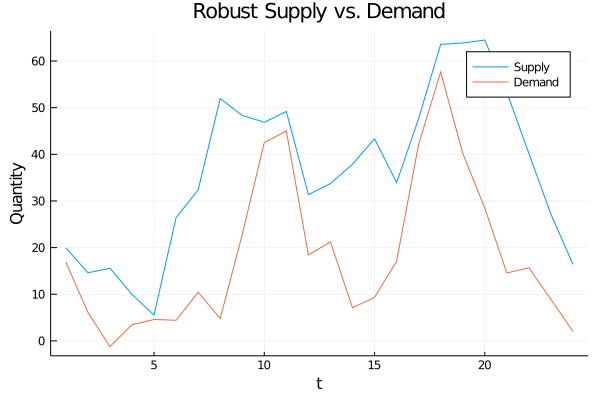

In [29]:
pval=prices_budget[6]
println(pval)
plot(s.*pval, label="Supply", xlabel = "t", ylabel = "Quantity", title = "Robust Supply vs. Demand")
plot!(α.-pval.*β, label="Demand")

### Robust Problem with Polyhedral Uncertainty Set

In [30]:
function optimize_polyhedral(d, P_t, D)
    m = Model(solver = GurobiSolver(OutputFlag=1))
    @variable(m, p[1:n_periods] >= 0.1)
    @variable(m, v[1:n_periods]>=0) #it will never be negative
    @variable(m, τ)
    
    #Polyhedral constraints
    ydim=size(d)[1]
    @variable(m, y[1:ydim]>=0)
    
    @variable(m,y_t[1:ydim,1:n_periods]>=0)


    @constraint(m,
        sum(p[t]*p[t]*r[t]*β[t]+p[t]*δ[t]*β[t]-p[t]*(r[t]*α[t]-δ[t]*s[t])-δ[t]*α[t] for t=1:n_periods)+τ
        +sum(d[i]*y[i] for i=1:2(n_periods-1)) 
    <=0
    )
        #This is just to avoid matrix notation here. Which will make the problem slower(?)
    @constraint(m,[t=1:n_periods], sum(D[i,t]*y[i] for i=1:ydim)==v[t])

    
    
    
    @constraint(m, [t=1:n_periods], θ[t]*r[t]*p[t]*p[t]+θ[t]*p[t]*δ[t]<=v[t])
    #V

    #robust counterpart of the supply>=demand constraint
    
    @constraint(m, [t=1:n_periods], -(s[t]+β[t])*p[t]+α[t]+
        sum(d[i]*y_t[i,t] for i=1:n_periods)#ρ*p[t]*θ[t]<=0)
    <=0)

    for t2 in 1:n_periods
        @constraint(m, [t=1:n_periods],sum(D[i,t]*y_t[i,t2] for i=1:ydim)==sum(P_t[t3,t,t2]*p[t3] for t3=1:n_periods))
    end
        
        #@constraint(m,[t=1:n_periods], sum(D[i,t]*y[i] for i=1:ydim)==v[t])
    
    #Price constraints
    @variable(m, p_abs[2:n_periods] >= 0)
    @constraint(m, [t=2:n_periods], p_abs[t] >= p[t] - p[t-1])
    @constraint(m, [t=2:n_periods], p_abs[t] >= -(p[t] - p[t-1]))
    @constraint(m, [t=2:n_periods], p_abs[t] <= 10) # price constraints
    
    @objective(m, Max, τ);
    
    solve(m)
    
    IJulia.clear_output()
    
    pval=JuMP.getvalue(p);
    obj_func=JuMP.getobjectivevalue(m)
    return pval, obj_func
end

optimize_polyhedral (generic function with 1 method)

In [31]:
D=zeros(((n_periods-1),n_periods))
z_positive=zeros((n_periods,n_periods))
[z_positive[t,t]=-1 for t=1:n_periods]
[D[t,t]=1 for t=1:(n_periods-2)]
[D[t,t+1]=1 for t=1:(n_periods-2)]
[D[t,t+2]=1 for t=1:(n_periods-2)]
d=ones(size(D)[1])*1;
D=vcat(D,z_positive)
d=vcat(d, zeros(n_periods))
;

In [32]:
P_t=zeros((n_periods,n_periods,n_periods))
[P_t[t,t,t]=-θ[t] for t=1:n_periods];

In [33]:
pval, obj_func=optimize_polyhedral(d, P_t, D);

In [34]:
obj_func

8922.157874845649

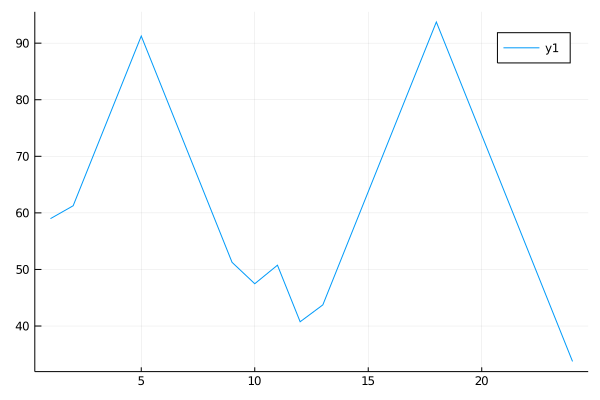

In [35]:
plot(pval)

# Simulation (box uncertainty)

In [36]:
# have norminal solution prices
p_nominal
# define penalty for violating S >= D constraints
SD_penalty = 500
# solve for robust solution prices 
ρ=1;
pval, obj_func=optimize_box(ρ);

π_nom = []
π_rob = []

for i in range(0,stop=2000)
    # Draw a random vector of z's from our uncertainty set 
    z = generate_z_box(ρ,1,24)
    β_sim = β.+θ.*z'

    s_nom = s.*p_nominal;
    d_nom = max.(α.-p_nominal.*β_sim,0);
    v_nom = s_nom .- d_nom;

    s_rob = s.*pval;
    d_rob = max.(α.-pval.*β_sim,0);
    v_rob = s_rob .- d_rob;
    
    penalty_nom = [if x<0 x else 0 end for x in v_nom]*SD_penalty
    penalty_rob = [if x<0 x else 0 end for x in v_rob]*SD_penalty
    
    append!(π_nom, sum(min.(d_nom).*p_nominal.*r - max.(v_nom,0).*δ + penalty_nom))
    append!(π_rob, sum(min.(d_rob).*pval.*r - max.(v_rob,0).*δ +penalty_rob))
end

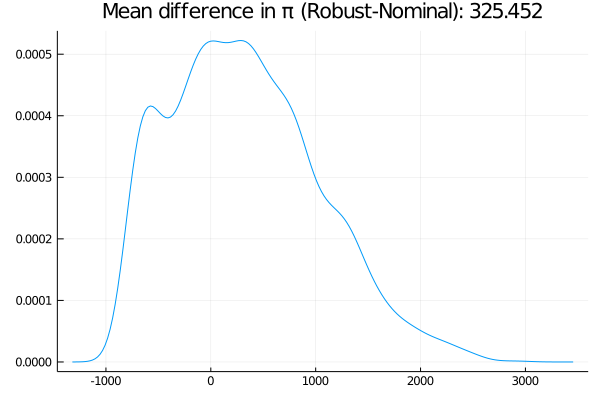

In [37]:
prof_difference=π_rob.-π_nom

density(prof_difference, legend = false,
title = "Mean difference in π (Robust-Nominal): "*string(round(mean(prof_difference), digits = 3)))

# Simulation (Budget uncertainty)

In [38]:
# have norminal solution prices
p_nominal
# define penalty for violating S >= D constraints 
SD_penalty = 500
# solve for robust solution prices 
ρ=1;
Γ=15
pval, obj_func=optimize_budget(ρ,Γ);

π_nom = []
π_rob = []

for i in range(0,stop=2000)
    # Draw a random vector of z's from our uncertainty set 
    z = generate_z_budget(ρ,Γ,1,24)
    β_sim = β.+θ.*z'

    s_nom = s.*p_nominal;
    d_nom = max.(α.-p_nominal.*β_sim,0);
    v_nom = s_nom .- d_nom;

    s_rob = s.*pval;
    d_rob = max.(α.-pval.*β_sim,0);
    v_rob = s_rob .- d_rob;

    append!(π_nom, sum(min.(d_nom).*p_nominal.*r - max.(v_nom,0).*δ + min.(v_nom,0)*SD_penalty))
    append!(π_rob, sum(min.(d_rob).*pval.*r - max.(v_rob,0).*δ + min.(v_rob,0)*SD_penalty))
end

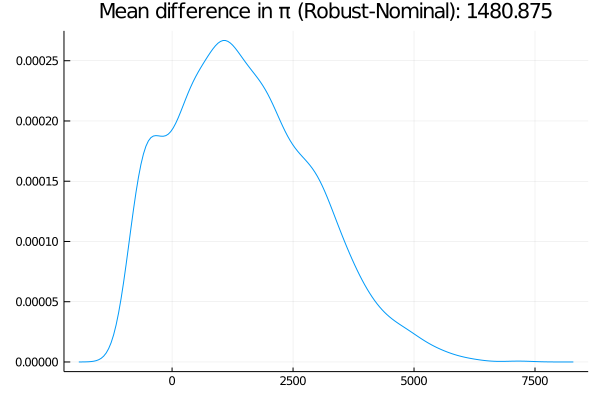

In [39]:
prof_difference=π_rob.-π_nom

density(prof_difference, legend = false, title = "Mean difference in π (Robust-Nominal): "*string(round(mean(prof_difference), digits = 3)))

# Simulation (Polyhedral uncertainty)

In [40]:
# have norminal solution prices
p_nominal
# define penalty for violating S >= D constraints 
SD_penalty = 500
# solve for robust solution prices 


D=zeros(((n_periods-1),n_periods))
z_positive=zeros((n_periods,n_periods))
[z_positive[t,t]=-1 for t=1:n_periods]
[D[t,t]=1 for t=1:(n_periods-2)]
[D[t,t+1]=1 for t=1:(n_periods-2)]
[D[t,t+2]=1 for t=1:(n_periods-2)]
d=ones(size(D)[1])*1;
D=vcat(D,z_positive)
d=vcat(d, zeros(n_periods))
pval, obj_func=optimize_polyhedral(d, P_t, D);

π_nom = []
π_rob = []

for i in range(0,stop=2000)
    # Draw a random vector of z's from our uncertainty set 
    #z = generate_z_budget(ρ,Γ,1,24)
    z = generate_z_poly(D,d,1,24)
    β_sim = β.+θ.*z'

    s_nom = s.*p_nominal;
    d_nom = max.(α.-p_nominal.*β_sim,0);
    v_nom = s_nom .- d_nom;

    s_rob = s.*pval;
    d_rob = max.(α.-pval.*β_sim,0);
    v_rob = s_rob .- d_rob;

    append!(π_nom, sum(min.(d_nom).*p_nominal.*r - max.(v_nom,0).*δ + min.(v_nom,0)*SD_penalty))
    append!(π_rob, sum(min.(d_rob).*pval.*r - max.(v_rob,0).*δ + min.(v_rob,0)*SD_penalty))
end

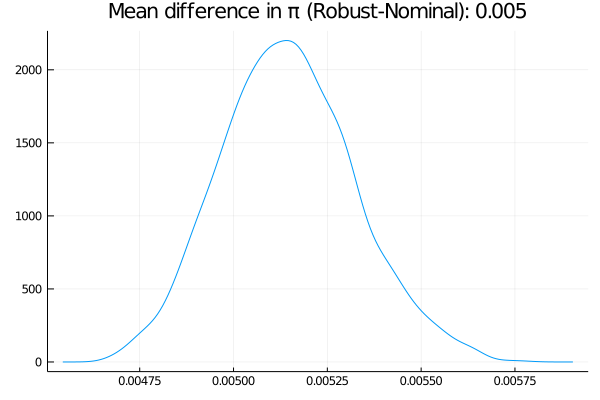

In [41]:
prof_difference=π_rob.-π_nom

density(prof_difference, legend = false, title = "Mean difference in π (Robust-Nominal): "*string(round(mean(prof_difference), digits = 3)))

# Simulation (general Z)

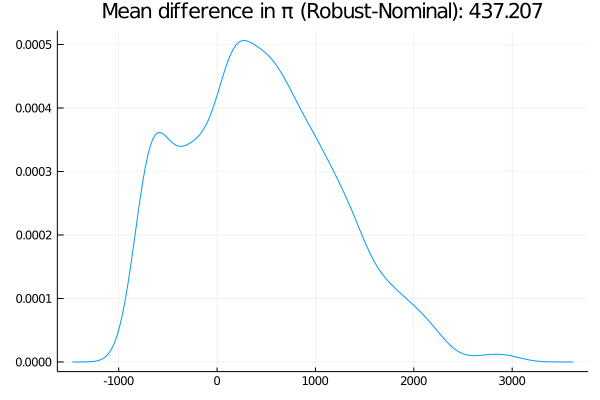

In [65]:
# have norminal solution prices
p_nominal
# define penalty for violating S >= D constraints
SD_penalty = 200
# solve for robust solution prices 
ρ=1;
pval, obj_func=optimize_box(ρ);

π_nom = []
π_rob = []

for i in range(0,stop=2000)
    # Draw a random vector of z's from our uncertainty set 
    z = rand(Normal(0, 1), 1, 24)
    β_sim = β.+θ.*z'

    s_nom = s.*p_nominal;
    d_nom = max.(α.-p_nominal.*β_sim,0);
    v_nom = s_nom .- d_nom;

    s_rob = s.*pval;
    d_rob = max.(α.-pval.*β_sim,0);
    v_rob = s_rob .- d_rob;
    
    penalty_nom = [if x<0 x else 0 end for x in v_nom]*SD_penalty
    penalty_rob = [if x<0 x else 0 end for x in v_rob]*SD_penalty
    
    append!(π_nom, sum(min.(d_nom).*p_nominal.*r - max.(v_nom,0).*δ + penalty_nom))
    append!(π_rob, sum(min.(d_rob).*pval.*r - max.(v_rob,0).*δ +penalty_rob))
end

prof_difference=π_rob.-π_nom

density(prof_difference, legend = false,
title = "Mean difference in π (Robust-Nominal): "*string(round(mean(prof_difference), digits = 3)))

# Folding horizon approach

- The here and now decision is price at time 1, with adaptive variables t+1, .... t=24
- Setup is that each hour, you can predict the next period's demand $\beta$
Procedure
1. Start at $t=0$
2. At time $t$ observe information about z at $t+1$. This is like saying standing at the current time, we look at traffic patterns and have some idea what the next hour is going to look like.
3. Optimize a price for the next period given known demand, as well as future prices while accounting for the fact that prices have to be connected. At each iteration we have to reset the optimization problem. 

In [66]:
function folding_horizon(T, p_fixed, z, ρ)
    """
    assume BOX uncertainty
    T = current timestep
    p_fixed = series of actual prices (1 to 24)
    z = realized uncertainties throughout time (1 to 24)
    """
    m = Model(solver = GurobiSolver(OutputFlag=0))
    @variable(m, p[1:n_periods] >= 0)
    @variable(m, v[1:n_periods]>=0) 
    @variable(m, τ)
    @variable(m, p_abs[2:n_periods] >= 0)
    @constraint(m, [t=2:n_periods], p_abs[t] >= p[t] - p[t-1]) 
    @constraint(m, [t=2:n_periods], p_abs[t] >= -(p[t] - p[t-1])) 
    @constraint(m, [t=2:n_periods], p_abs[t] <= 10) # price constraints

    # fix the prices for the previous periods
    for t in range(1,stop = T)
        @constraint(m, p[t]==p_fixed[t])
    end

    # DETERMINISTIC optimization of price for the immediate next period T+1 (since we assume z is revealed)
    # Note that price change |p_{t} - p_{t+1}| <= 10 constraint still applies
    @variable(m, μ)
    @constraint(m, μ <= (α[T+1]-(β[T+1]+θ[T+1]*z[T+1])*p[T+1])*r[T+1]-δ[T+1]*v[T+1]) # single step profit (α[t]-β[t]*p[t])*(r[t])*p[t] - δ[t]*v[t]
    @constraint(m, α[T+1]-(β[T+1]+θ[T+1]*z[T+1])*p[T+1] <= s[T+1]*p[T+1]) # single step S[T+1] >= D[T+1]
    
    if T <= 22
        # ROBUST optimize prices for all remaining periods 
        @constraint(m,sum(p[t]*p[t]*r[t]*β[t]+δ[t]*p[t]*β[t]-p[t]*(r[t]*α[t]-δ[t]*s[t])-δ[t]*α[t] for t=(T+2):n_periods)+τ+ρ*sum(v)<=0)
        @constraint(m, [t=(T+2):n_periods], θ[t]*r[t]*p[t]*p[t]+δ[t]*θ[t]*p[t]<=v[t])
        @constraint(m, [t=(T+2):n_periods], -(s[t]+β[t])*p[t]+α[t]+ρ*p[t]*θ[t]<=0)
    else
        @constraint(m, τ <= 0)
    end
    # Place both epigraph variables into objective 
    @objective(m, Max, μ+τ);
    solve(m)
    
    return getvalue.(p)[T+1]
end

folding_horizon (generic function with 1 method)

In [67]:
ρ = 1
# z = generate_z_box(ρ,1,24);
z = rand(Normal(0, 1), 1, 24)
pval, obj_func=optimize_box(ρ);
p_fixed = []; # start with solution of robust problem

for t in range(0, stop = 23)
    next_p = folding_horizon(t, p_fixed, z, ρ)
    append!(p_fixed,next_p)
end

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

In [68]:
# Compare robust fixed vs. robust folding horizon
β_sim = β.+θ.*z'

s_rob = s.*pval;
d_rob = max.(α.-pval.*β_sim,0);
v_rob = s_rob .- d_rob;

s_fh = s.*p_fixed;
d_fh = max.(α.-p_fixed.*β_sim,0);
v_fh = s_fh .- d_fh;

SD_penalty=100

100

In [69]:
sum(min.(d_rob).*pval.*r - max.(v_rob,0).*δ + min.(v_rob,0)*SD_penalty)

9212.548801396653

In [70]:
sum(min.(d_fh).*p_fixed.*r - max.(v_fh,0).*δ + min.(v_fh,0)*SD_penalty)

9556.76101934078

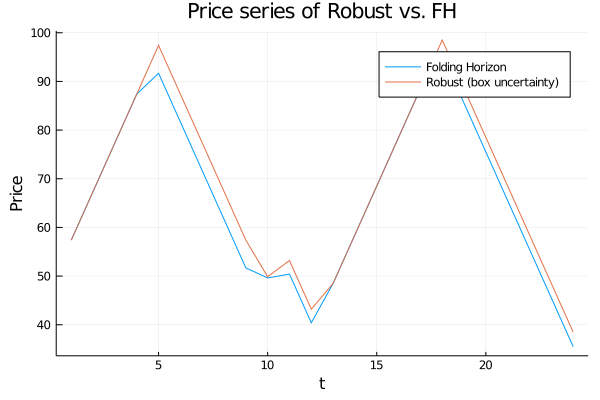

In [71]:
plot(p_fixed, label="Folding Horizon", title = "Price series of Robust vs. FH", xlabel = "t", ylabel = "Price")
plot!(pval, label = "Robust (box uncertainty)")

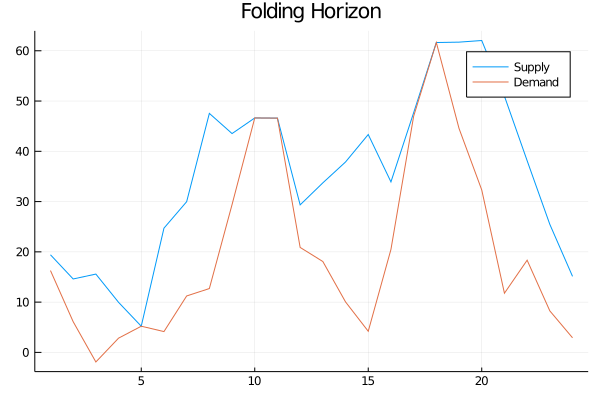

In [72]:
plot(s.*p_fixed, label="Supply", title = "Folding Horizon")
plot!(α.-p_fixed.*β_sim, label="Demand")

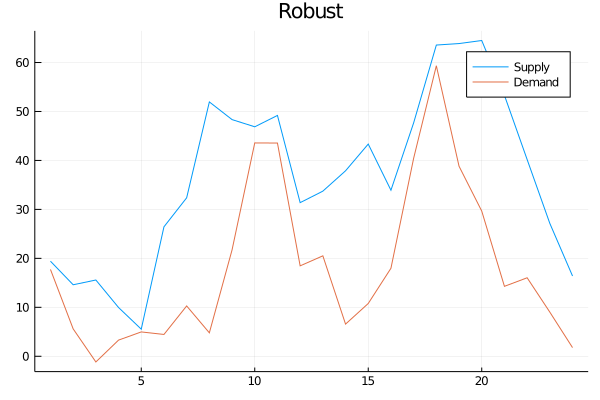

In [49]:
plot(s.*pval, label="Supply", title = "Robust")
plot!(α.-pval.*β_sim, label="Demand")

# Folding Horizon Simulation

In [77]:
# Now we simulate the advantage that folding horizon provides over the robust case 
π_rob = []
π_fh = []
SD_penalty=100

ρ = 1
pval, obj_func=optimize_box(ρ);

for i in range(0, stop= 50)
    # simulate
    z = generate_z_box(ρ,1,24);
#     z = rand(Normal(0, 0.1), 1, 24)
    p_fixed = []; 
    for t in range(0, stop = 23)
        next_p = folding_horizon(t, p_fixed, z, ρ)
        append!(p_fixed,next_p)
    end
    
    # compute profits 
    β_sim = β.+θ.*z'

    s_rob = s.*pval;
    d_rob = max.(α.-pval.*β_sim,0);
    v_rob = s_rob .- d_rob;

    s_fh = s.*p_fixed;
    d_fh = max.(α.-p_fixed.*β_sim,0);
    v_fh = s_fh .- d_fh;
    
    append!(π_rob, sum(min.(d_rob).*pval.*r - max.(v_rob,0).*δ + min.(v_rob,0)*SD_penalty))
    append!(π_fh, sum(min.(d_fh).*p_fixed.*r - max.(v_fh,0).*δ + min.(v_fh,0)*SD_penalty))
end

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

┌ Warning: Not solved to optimality, status: Suboptimal
└ @ JuMP C:\Users\brian\.julia\packages\JuMP\I7whV\src\solvers.jl:212
┌ Warning: Not solved to optimality, status: Suboptimal
└ @ JuMP C:\Users\brian\.julia\packages\JuMP\I7whV\src\solvers.jl:212


Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

Academic license - for non-commercial use only


┌ Warning: Gurobi reported infeasible or unbounded. Set InfUnbdInfo=1 for more specific status.
└ @ Gurobi C:\Users\brian\.julia\packages\Gurobi\VhpiN\src\MPB_wrapper.jl:438
┌ Warning: Not solved to optimality, status: InfeasibleOrUnbounded
└ @ JuMP C:\Users\brian\.julia\packages\JuMP\I7whV\src\solvers.jl:212
┌ Warning: Variable value not defined for p[1]. Check that the model was properly solved.
└ @ JuMP C:\Users\brian\.julia\packages\JuMP\I7whV\src\JuMP.jl:453
┌ Warning: Variable value not defined for p[2]. Check that the model was properly solved.
└ @ JuMP C:\Users\brian\.julia\packages\JuMP\I7whV\src\JuMP.jl:453
┌ Warning: Variable value not defined for p[3]. Check that the model was properly solved.
└ @ JuMP C:\Users\brian\.julia\packages\JuMP\I7whV\src\JuMP.jl:453
┌ Warning: Variable value not defined for p[4]. Check that the model was properly solved.
└ @ JuMP C:\Users\brian\.julia\packages\JuMP\I7whV\src\JuMP.jl:453
┌ Warning: Variable value not defined for p[5]. Check that th

AssertionError: AssertionError: rowub[i] < posinf

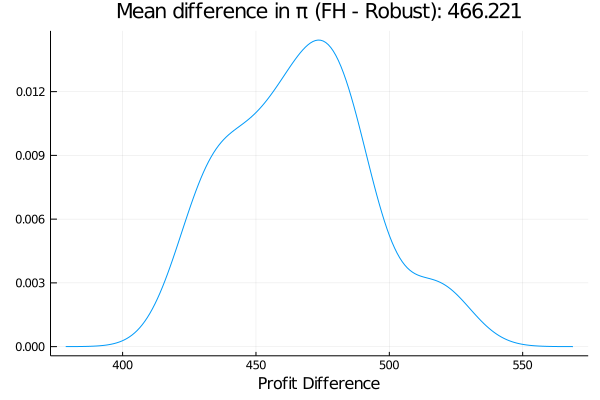

In [78]:
prof_difference=π_fh.-π_rob

density(prof_difference, legend = false,xlabel = "Profit Difference", title = "Mean difference in π (FH - Robust): "*string(round(mean(prof_difference), digits = 3)))

# Now with Budget uncertainty set

In [52]:
function optimize_budget(ρ, Γ)
    m = Model(solver = GurobiSolver(OutputFlag=1))
    @variable(m, p[1:n_periods] >= 0)
    @variable(m, v[1:n_periods]>=0) #it will never be negative
    @variable(m, τ)
    @variable(m, y[1:n_periods])
    @variable(m, y_abs[1:n_periods]>=0)
    @variable(m, inf_norm)
    


    @constraint(m,
        sum(p[t]*p[t]*r[t]*β[t]+δ[t]*p[t]*β[t]-p[t]*(r[t]*α[t]-δ[t]*s[t])-δ[t]*α[t] for t=1:n_periods)+τ+
        ρ*sum(y_abs)+Γ*inf_norm<=0)
    
    #These are some auxiliary constraints to find the conjugate of v|Z. This involves calculating the inf
    #norm of v-y
    @constraint(m, [t=1:n_periods],v[t]-y[t]<=inf_norm)
    @constraint(m, [t=1:n_periods],-v[t]+y[t]<=inf_norm)
    
    @constraint(m, [t=1:n_periods], y[t]<=y_abs[t])
    @constraint(m, [t=1:n_periods], -y[t]<=y_abs[t])

    @constraint(m, [t=1:n_periods], θ[t]*r[t]*p[t]*p[t]+δ[t]*θ[t]*p[t]<=v[t])


    #robust counterpart of the supply>=demand constraint
    @variable(m, y2[1:n_periods])
    @variable(m, y2_abs[1:n_periods]>=0)
    @variable(m, inf_norm2[1:n_periods])
    @constraint(m, [t=1:n_periods], -(s[t]+β[t])*p[t]+α[t]+
        ρ*y2_abs[t]+Γ*inf_norm2[t]<=0)#ρ*p[t]*θ[t]<=0)
    @constraint(m, [t=1:n_periods], y2[t]<=y2_abs[t])
    @constraint(m, [t=1:n_periods], -y2[t]<=y2_abs[t])
    
    @constraint(m, [t=1:n_periods], -θ[t]*p[t]-y2[t]<=inf_norm2[t])
    @constraint(m, [t=1:n_periods], +θ[t]*p[t]+y2[t]<=inf_norm2[t])
    
    
    @variable(m, p_abs[2:n_periods] >= 0)
    @constraint(m, [t=2:n_periods], p_abs[t] >= p[t] - p[t-1])
    @constraint(m, [t=2:n_periods], p_abs[t] >= -(p[t] - p[t-1]))
    @constraint(m, [t=2:n_periods], p_abs[t] <= 10) # price constraints
    #Price constraints
    @variable(m, p_abs[2:n_periods] >= 0)
    @constraint(m, [t=2:n_periods], p_abs[t] >= p[t] - p[t-1])
    @constraint(m, [t=2:n_periods], p_abs[t] >= -(p[t] - p[t-1]))
    @constraint(m, [t=2:n_periods], p_abs[t] <= 10) # price constraints
    
    @objective(m, Max, τ);
    
    solve(m)
    
    IJulia.clear_output()
    
    pval=JuMP.getvalue(p);
    obj_func=JuMP.getobjectivevalue(m)
    return pval, obj_func
end

optimize_budget (generic function with 1 method)

In [53]:
function folding_horizon_budget(T, p_fixed, z, ρ, Γ)
    """
    assume BUDGET uncertainty
    T = current timestep
    p_fixed = series of actual prices (1 to 24)
    z = realized uncertainties throughout time (1 to 24)
    """
    m = Model(solver = GurobiSolver(OutputFlag=0))
    @variable(m, p[1:n_periods] >= 0)
    @variable(m, v[1:n_periods]>=0) 
    @variable(m, τ)
    
    
    @variable(m, p_abs[2:n_periods] >= 0)
    @constraint(m, [t=2:n_periods], p_abs[t] >= p[t] - p[t-1]) 
    @constraint(m, [t=2:n_periods], p_abs[t] >= -(p[t] - p[t-1])) 
    @constraint(m, [t=2:n_periods], p_abs[t] <= 10) # price constraints
    
    @variable(m, y[1:n_periods])
    @variable(m, y_abs[1:n_periods]>=0)
    @variable(m, inf_norm)
    

    # fix the prices for the previous periods
    for t in range(1,stop = T)
        @constraint(m, p[t]==p_fixed[t])
    end

    # DETERMINISTIC optimization of price for the immediate next period T+1 (since we assume z is revealed)
    # Note that price change |p_{t} - p_{t+1}| <= 10 constraint still applies
    @variable(m, μ)
    @constraint(m, μ <= (α[T+1]-(β[T+1]+θ[T+1]*z[T+1])*p[T+1])*r[T+1]-δ[T+1]*v[T+1]) # single step profit (α[t]-β[t]*p[t])*(r[t])*p[t] - δ[t]*v[t]
    @constraint(m, α[T+1]-(β[T+1]+θ[T+1]*z[T+1])*p[T+1] <= s[T+1]*p[T+1]) # single step S[T+1] >= D[T+1]
    
    if T <= 22
        # ROBUST optimize prices for all remaining periods 
        @constraint(m,sum(p[t]*p[t]*r[t]*β[t]+δ[t]*p[t]*β[t]-p[t]*(r[t]*α[t]-δ[t]*s[t])-δ[t]*α[t] for t=(T+2):n_periods)+τ
            +ρ*sum(y_abs)+Γ*inf_norm<=0)
        @constraint(m, [t=(T+2):n_periods],v[t]-y[t]<=inf_norm)
        @constraint(m, [t=(T+2):n_periods],-v[t]+y[t]<=inf_norm)

        @constraint(m, [t=(T+2):n_periods], y[t]<=y_abs[t])
        @constraint(m, [t=(T+2):n_periods], -y[t]<=y_abs[t])
        
        @constraint(m, [t=(T+2):n_periods], θ[t]*r[t]*p[t]*p[t]+δ[t]*θ[t]*p[t]<=v[t])
        
        
        #Supply>=Demand
        #@constraint(m, [t=(T+2):n_periods], -(s[t]+β[t])*p[t]+α[t]
            #+ρ*p[t]*θ[t]<=0)
        
        @variable(m, y2[1:n_periods])
        @variable(m, y2_abs[1:n_periods]>=0)
        @variable(m, inf_norm2[1:n_periods])
        @constraint(m, [t=(T+2):n_periods], -(s[t]+β[t])*p[t]+α[t]+
            ρ*y2_abs[t]+Γ*inf_norm2[t]<=0)#ρ*p[t]*θ[t]<=0)
        @constraint(m, [t=(T+2):n_periods], y2[t]<=y2_abs[t])
        @constraint(m, [t=(T+2):n_periods], -y2[t]<=y2_abs[t])

        @constraint(m, [t=(T+2):n_periods], -θ[t]*p[t]-y2[t]<=inf_norm2[t])
        @constraint(m, [t=(T+2):n_periods], +θ[t]*p[t]+y2[t]<=inf_norm2[t])
    else
        @constraint(m, τ <= 0)
    end
    # Place both epigraph variables into objective 
    @objective(m, Max, μ+τ);
    solve(m)
    
    return getvalue.(p)[T+1]
end

folding_horizon_budget (generic function with 1 method)

In [54]:
ρ = 1
Γ = 15
z = generate_z_budget(ρ,Γ,1,24);

pval, obj_func=optimize_budget(ρ, Γ);

p_fixed = []; # start with solution of robust problem

for t in range(0, stop = 23)
    next_p = folding_horizon_budget(t, p_fixed, z, ρ, Γ)#folding_horizon(t, p_fixed, z, ρ)
    append!(p_fixed,next_p)
end

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

In [55]:
# Compare robust fixed vs. robust folding horizon
β_sim = β.+θ.*z'

s_rob = s.*pval;
d_rob = max.(α.-pval.*β_sim,0);
v_rob = s_rob .- d_rob;

s_fh = s.*p_fixed;
d_fh = max.(α.-p_fixed.*β_sim,0);
v_fh = s_fh .- d_fh;

SD_penalty=100

100

In [56]:
sum(min.(d_rob).*pval.*r - max.(v_rob,0).*δ + min.(v_rob,0)*SD_penalty)

8092.68262513514

In [57]:
sum(min.(d_fh).*p_fixed.*r - max.(v_fh,0).*δ + min.(v_fh,0)*SD_penalty)

8834.97626810371

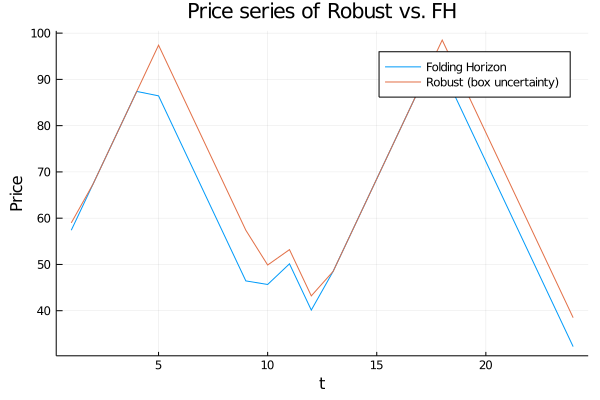

In [58]:
plot(p_fixed, label="Folding Horizon", title = "Price series of Robust vs. FH", xlabel = "t", ylabel = "Price")
plot!(pval, label = "Robust (box uncertainty)")

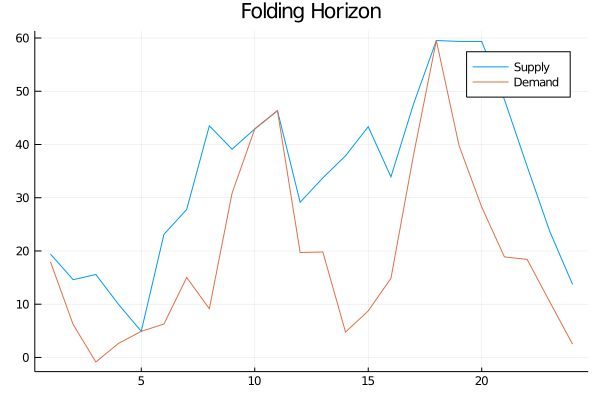

In [59]:
plot(s.*p_fixed, label="Supply", title = "Folding Horizon")
plot!(α.-p_fixed.*β_sim, label="Demand")

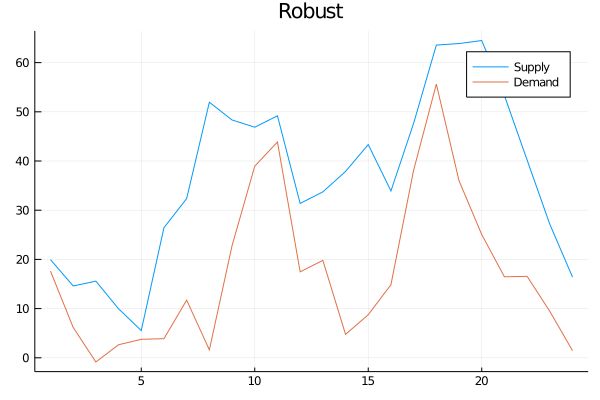

In [60]:
plot(s.*pval, label="Supply", title = "Robust")
plot!(α.-pval.*β_sim, label="Demand")

# Folding Horizon Simulation

In [61]:
# Now we simulate the advantage that folding horizon provides over the robust case 
π_rob = []
π_fh = []
SD_penalty=100

ρ = 1
Γ = 15
pval, obj_func=optimize_budget(ρ, Γ);;

#generate_z_budget(ρ,Γ,1,24)
function folding_horizon
for i in range(0, stop= 50)
    # simulate
    z = generate_z_budget(ρ,Γ,1,24);
    p_fixed = []; 
    for t in range(0, stop = 23)
        next_p = folding_horizon_box(t, p_fixed, z, ρ, Γ)
        
        append!(p_fixed,next_p)
    end
    
    # compute profits 
    β_sim = β.+θ.*z'

    s_rob = s.*pval;
    d_rob = max.(α.-pval.*β_sim,0);
    v_rob = s_rob .- d_rob;

    s_fh = s.*p_fixed;
    d_fh = max.(α.-p_fixed.*β_sim,0);
    v_fh = s_fh .- d_fh;
    
    append!(π_rob, sum(min.(d_rob).*pval.*r - max.(v_rob,0).*δ + min.(v_rob,0)*SD_penalty))
    append!(π_fh, sum(min.(d_fh).*p_fixed.*r - max.(v_fh,0).*δ + min.(v_fh,0)*SD_penalty))
end

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

┌ Warning: Gurobi reported infeasible or unbounded. Set InfUnbdInfo=1 for more specific status.
└ @ Gurobi C:\Users\brian\.julia\packages\Gurobi\VhpiN\src\MPB_wrapper.jl:438
┌ Warning: Not solved to optimality, status: InfeasibleOrUnbounded
└ @ JuMP C:\Users\brian\.julia\packages\JuMP\I7whV\src\solvers.jl:212
┌ Warning: Variable value not defined for p[1]. Check that the model was properly solved.
└ @ JuMP C:\Users\brian\.julia\packages\JuMP\I7whV\src\JuMP.jl:453
┌ Warning: Variable value not defined for p[2]. Check that the model was properly solved.
└ @ JuMP C:\Users\brian\.julia\packages\JuMP\I7whV\src\JuMP.jl:453
┌ Warning: Variable value not defined for p[3]. Check that the model was properly solved.
└ @ JuMP C:\Users\brian\.julia\packages\JuMP\I7whV\src\JuMP.jl:453
┌ Warning: Variable value not defined for p[4]. Check that the model was properly solved.
└ @ JuMP C:\Users\brian\.julia\packages\JuMP\I7whV\src\JuMP.jl:453
┌ Warning: Variable value not defined for p[5]. Check that th

AssertionError: AssertionError: rowub[i] < posinf

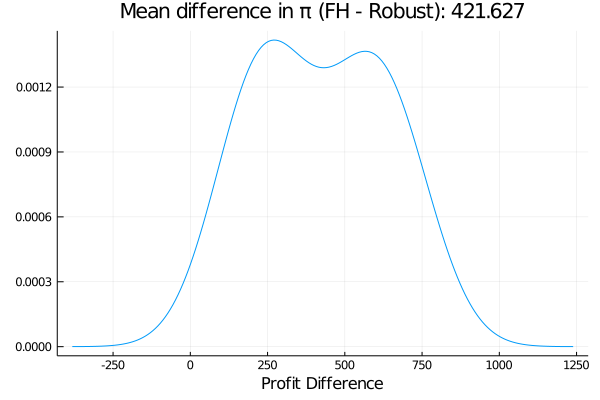

In [62]:
prof_difference=π_fh.-π_rob

density(prof_difference, legend = false,xlabel = "Profit Difference", title = "Mean difference in π (FH - Robust): "*string(round(mean(prof_difference), digits = 3)))

# Folding horizon simulation with Gaussian predictive errors

In [216]:
function folding_horizon_mod(T, p_fixed, z, ρ)
    """
    assume BOX uncertainty
    T = current timestep
    p_fixed = series of actual prices (1 to 24)
    z = realized uncertainties throughout time (1 to 24)
    """
    m = Model(solver = GurobiSolver(OutputFlag=0))
    @variable(m, p[1:n_periods] >= 0)
    @variable(m, v[1:n_periods]>=0) 
    @variable(m, τ)
    @variable(m, p_abs[2:n_periods] >= 0)
    @constraint(m, [t=2:n_periods], p_abs[t] >= p[t] - p[t-1]) 
    @constraint(m, [t=2:n_periods], p_abs[t] >= -(p[t] - p[t-1])) 
    @constraint(m, [t=2:n_periods], p_abs[t] <= 10) # price constraints

    # fix the prices for the previous periods
    for t in range(1,stop = T)
        @constraint(m, p[t]==p_fixed[t])
    end

    # DETERMINISTIC optimization of price for the immediate next period T+1 (since we assume z is revealed)
    # Note that price change |p_{t} - p_{t+1}| <= 10 constraint still applies
    @variable(m, μ)
    @constraint(m, μ <= (α[T+1]-(z[T+1])*p[T+1])*r[T+1]-δ[T+1]*v[T+1]) # single step profit (α[t]-β[t]*p[t])*(r[t])*p[t] - δ[t]*v[t]
    @constraint(m, α[T+1]-(z[T+1])*p[T+1] <= s[T+1]*p[T+1]) # single step S[T+1] >= D[T+1]
    
    if T <= 22
        # ROBUST optimize prices for all remaining periods 
        @constraint(m,sum(p[t]*p[t]*r[t]*β[t]+δ[t]*p[t]*β[t]-p[t]*(r[t]*α[t]-δ[t]*s[t])-δ[t]*α[t] for t=(T+2):n_periods)+τ+ρ*sum(v)<=0)
        @constraint(m, [t=(T+2):n_periods], θ[t]*r[t]*p[t]*p[t]+δ[t]*θ[t]*p[t]<=v[t])
        @constraint(m, [t=(T+2):n_periods], -(s[t]+β[t])*p[t]+α[t]+ρ*p[t]*θ[t]<=0)
    else
        @constraint(m, τ <= 0)
    end
    # Place both epigraph variables into objective 
    @objective(m, Max, μ+τ);
    status = solve(m)
    if status == :Optimal
        return getvalue.(p)[T+1]
    else
        return -1
    end
end

folding_horizon_mod (generic function with 2 methods)

In [217]:
function rsq(actual, predicted)
    SST = sum((actual .- mean(actual)).^2)
    SSR = sum((predicted.-actual).^2)
    return 1-(SSR/SST)
end

rsq (generic function with 1 method)

In [284]:
# Now we simulate the advantage that folding horizon provides over the robust case 


π_rob = []
π_fh = []
rsq_list = []
SD_penalty=250
error_size = 1

ρ = 3
pval, obj_func=optimize_box(ρ);

for i in range(0, stop= 100)
    # Generate beta
    z = rand(Normal(0, 1), 1, 24) 
#     z = generate_z_box(ρ,1,24)
    # Induce errors
    predictive_error = [rand(Normal(0, θ[t]))*error_size for t in 1:24]
    actual = β.+θ.*z'
    predicted = actual + predictive_error
    print(predicted)
    # Quantify size of error 
    r_squared = rsq(actual, predicted)
    p_fixed = []; 
    flag = 0
    for t in range(0, stop = 23)
        next_p = folding_horizon_mod(t, p_fixed, predicted, ρ)
        if next_p == -1 # could not solve 
            println("Could not solve for realization of prediction error")
            flag = 1
            break
        else
            append!(p_fixed,next_p)
        end
    end
    if flag == 1
        continue # can't solve for this realization of errors
    end
    # compute profits 
    β_sim = β.+θ.*z'

    s_rob = s.*pval;
    d_rob = max.(α.-pval.*β_sim,0);
    v_rob = s_rob .- d_rob;

    s_fh = s.*p_fixed;
    d_fh = max.(α.-p_fixed.*β_sim,0);
    v_fh = s_fh .- d_fh;

    append!(π_rob, sum(min.(d_rob).*pval.*r - max.(v_rob,0).*δ + min.(v_rob,0)*SD_penalty))
    append!(π_fh, sum(min.(d_fh).*p_fixed.*r - max.(v_fh,0).*δ + min.(v_fh,0)*SD_penalty))
    append!(rsq_list, r_squared)
end

prof_difference=π_fh.-π_rob
prof_difference, rsq_list  

[0.233162; 0.117364; 0.061809; 0.0749815; 0.0861202; 0.147658; 0.333545; 0.677124; 0.592731; 0.892197; 0.834157; 0.438808; 0.688844; 0.634545; 0.628676; 0.534495; 0.56714; 0.527703; 0.471721; 0.41543; 0.378563; 0.391007; 0.146874; 0.131607]Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic

┌ Warning: Not solved to optimality, status: Suboptimal
└ @ JuMP C:\Users\brian\.julia\packages\JuMP\I7whV\src\solvers.jl:212


Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

┌ Warning: Not solved to optimality, status: Suboptimal
└ @ JuMP C:\Users\brian\.julia\packages\JuMP\I7whV\src\solvers.jl:212


Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

[0.225717; 0.166703; 0.0543271; 0.122994; 0.0968605; 0.236378; 0.355877; 0.572946; 0.767341; 0.98745; 0.734233; 0.743722; 0.745771; 0.489934; 0.466395; 0.44389; 0.479754; 0.597035; 0.516611; 0.382271; 0.351748; 0.294125; 0.211364; 0.179864]Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic

┌ Warning: Not solved to optimality, status: Suboptimal
└ @ JuMP C:\Users\brian\.julia\packages\JuMP\I7whV\src\solvers.jl:212


0564851; 0.113632; 0.101144; 0.20856; 0.227453; 0.665101; 0.85736; 0.858918; 0.811448; 0.514357; 0.731036; 0.652287; 0.517021; 0.288791; 0.548728; 0.724642; 0.472693; 0.357505; 0.470763; 0.26801; 0.152363; 0.159738]Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commer

┌ Warning: Not solved to optimality, status: Suboptimal
└ @ JuMP C:\Users\brian\.julia\packages\JuMP\I7whV\src\solvers.jl:212


Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

┌ Warning: Gurobi reported infeasible or unbounded. Set InfUnbdInfo=1 for more specific status.
└ @ Gurobi C:\Users\brian\.julia\packages\Gurobi\VhpiN\src\MPB_wrapper.jl:438
┌ Warning: Not solved to optimality, status: InfeasibleOrUnbounded
└ @ JuMP C:\Users\brian\.julia\packages\JuMP\I7whV\src\solvers.jl:212


Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

┌ Warning: Not solved to optimality, status: Suboptimal
└ @ JuMP C:\Users\brian\.julia\packages\JuMP\I7whV\src\solvers.jl:212


; 0.513842; 0.442597; 0.412363; 0.687309; 0.586042; 0.356607; 0.504977; 0.341975; 0.16756; 0.168311]Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academi

┌ Warning: Not solved to optimality, status: Suboptimal
└ @ JuMP C:\Users\brian\.julia\packages\JuMP\I7whV\src\solvers.jl:212


Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

┌ Warning: Not solved to optimality, status: Suboptimal
└ @ JuMP C:\Users\brian\.julia\packages\JuMP\I7whV\src\solvers.jl:212


Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Could not solve for realization of prediction error
[0.23163; 0.147763; 0.0708306; 0.0984915; 0.0807869; 0.238071; 0.315489; 0.518696; 0.699309; 0.830764; 0.917035; 0.552813; 0.529223; 0.559254; 0.400975; 0.496287; 0.525223; 0.574801; 0.478897; 0.501482; 0.463404; 0.240696; 0.177291; 0.179811]

┌ Warning: Gurobi reported infeasible or unbounded. Set InfUnbdInfo=1 for more specific status.
└ @ Gurobi C:\Users\brian\.julia\packages\Gurobi\VhpiN\src\MPB_wrapper.jl:438
┌ Warning: Not solved to optimality, status: InfeasibleOrUnbounded
└ @ JuMP C:\Users\brian\.julia\packages\JuMP\I7whV\src\solvers.jl:212


Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

┌ Warning: Not solved to optimality, status: Suboptimal
└ @ JuMP C:\Users\brian\.julia\packages\JuMP\I7whV\src\solvers.jl:212


[0.198086; 0.170513; 0.0621954; 0.117626; 0.117122; 0.196794; 0.327943; 0.690444; 0.552559; 0.766054; 0.852669; 0.627769; 0.734338; 0.534751; 0.52548; 0.515317; 0.440787; 0.553902; 0.618447; 0.529045; 0.468555; 0.385128; 0.190202; 0.178724]Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic

┌ Warning: Gurobi reported infeasible or unbounded. Set InfUnbdInfo=1 for more specific status.
└ @ Gurobi C:\Users\brian\.julia\packages\Gurobi\VhpiN\src\MPB_wrapper.jl:438
┌ Warning: Not solved to optimality, status: InfeasibleOrUnbounded
└ @ JuMP C:\Users\brian\.julia\packages\JuMP\I7whV\src\solvers.jl:212


Could not solve for realization of prediction error
[0.223041; 0.182866; 0.0472613; 0.112151; 0.0922397; 0.147934; 0.284885; 0.719482; 0.861595; 0.68705; 0.666696; 0.654517; 0.967314; 0.662867; 0.628715; 0.45272; 0.43133; 0.511464; 0.498302; 0.442682; 0.395735; 0.344553; 0.200354; 0.174595]Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Acad

[0.203951; 0.190021; 0.0550883; 0.115251; 0.121764; 0.231118; 0.313995; 0.815739; 0.764196; 0.820939; 0.632938; 0.71609; 0.737112; 0.661362; 0.548153; 0.404543; 0.465043; 0.757072; 0.566866; 0.507454; 0.474101; 0.315781; 0.211645; 0.159157]Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic

┌ Warning: Gurobi reported infeasible or unbounded. Set InfUnbdInfo=1 for more specific status.
└ @ Gurobi C:\Users\brian\.julia\packages\Gurobi\VhpiN\src\MPB_wrapper.jl:438
┌ Warning: Not solved to optimality, status: InfeasibleOrUnbounded
└ @ JuMP C:\Users\brian\.julia\packages\JuMP\I7whV\src\solvers.jl:212


0.800706; 0.707697; 0.820621; 0.781967; 0.517486; 0.621493; 0.45752; 0.434877; 0.55879; 0.638067; 0.661441; 0.439655; 0.335846; 0.292602; 0.181131; 0.193383]Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Could not solve for realization of prediction error
[0.248964; 0.185931; 0.0526411; 0.10101; 0.0804028; 0.22124; 0.275155; 0.471989; 0.607772; 1.10951; 0.578211; 0.850134; 0.709884; 0.558399; 0.510222; 0.471181; 0.443287; 0.567241; 

┌ Warning: Not solved to optimality, status: Suboptimal
└ @ JuMP C:\Users\brian\.julia\packages\JuMP\I7whV\src\solvers.jl:212


Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

[0.225626; 0.140468; 0.0614564; 0.116293; 0.113707; 0.235197; 0.250129; 0.783738; 0.559044; 0.972029; 0.965688; 0.729978; 0.679629; 0.581398; 0.618875; 0.299453; 0.519222; 0.61007; 0.583168; 0.4209; 0.382388; 0.205892; 0.168301; 0.156947]Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic l

┌ Warning: Not solved to optimality, status: Suboptimal
└ @ JuMP C:\Users\brian\.julia\packages\JuMP\I7whV\src\solvers.jl:212


[0.180402; 0.163061; 0.0546434; 0.095538; 0.090653; 0.197792; 0.294234; 0.542941; 0.566544; 0.984571; 0.849141; 0.740472; 0.655743; 0.607123; 0.61612; 0.478703; 0.46458; 0.577905; 0.577717; 0.503463; 0.359898; 0.304467; 0.15133; 0.117233]Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic l

┌ Warning: Not solved to optimality, status: Suboptimal
└ @ JuMP C:\Users\brian\.julia\packages\JuMP\I7whV\src\solvers.jl:212


Could not solve for realization of prediction error
[0.207202; 0.170164; 0.0530061; 0.0810943; 0.0870413; 0.221119; 0.343736; 0.720242; 0.831722; 0.891556; 0.861727; 0.633568; 0.8076; 0.664451; 0.557963; 0.410815; 0.416613; 0.576112; 0.450205; 0.483621; 0.402734; 0.362366; 0.211198; 0.091049]Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Ac

┌ Warning: Gurobi reported infeasible or unbounded. Set InfUnbdInfo=1 for more specific status.
└ @ Gurobi C:\Users\brian\.julia\packages\Gurobi\VhpiN\src\MPB_wrapper.jl:438
┌ Warning: Not solved to optimality, status: InfeasibleOrUnbounded
└ @ JuMP C:\Users\brian\.julia\packages\JuMP\I7whV\src\solvers.jl:212


Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Could not solve for realization of prediction error
[0.222254; 0.149624; 0.0622177; 0.0961056; 0.105551; 0.278547; 0.340702; 0.524223; 0.796964; 0.872067; 0.677846; 0.693684; 0.670308; 0.621893; 0.629497; 0.538848; 0.499845; 0.537776; 0.501319; 0.47447; 0.436107; 0.287407; 0.190464; 0.168323]

┌ Warning: Not solved to optimality, status: Suboptimal
└ @ JuMP C:\Users\brian\.julia\packages\JuMP\I7whV\src\solvers.jl:212


Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

┌ Warning: Not solved to optimality, status: Suboptimal
└ @ JuMP C:\Users\brian\.julia\packages\JuMP\I7whV\src\solvers.jl:212


Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

┌ Warning: Not solved to optimality, status: Suboptimal
└ @ JuMP C:\Users\brian\.julia\packages\JuMP\I7whV\src\solvers.jl:212


Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

┌ Warning: Not solved to optimality, status: Suboptimal
└ @ JuMP C:\Users\brian\.julia\packages\JuMP\I7whV\src\solvers.jl:212
┌ Warning: Gurobi reported infeasible or unbounded. Set InfUnbdInfo=1 for more specific status.
└ @ Gurobi C:\Users\brian\.julia\packages\Gurobi\VhpiN\src\MPB_wrapper.jl:438
┌ Warning: Not solved to optimality, status: InfeasibleOrUnbounded
└ @ JuMP C:\Users\brian\.julia\packages\JuMP\I7whV\src\solvers.jl:212


0.15274; 0.065051; 0.0811237; 0.0936072; 0.20776; 0.299604; 0.54844; 0.755203; 0.972385; 0.771047; 0.893867; 0.643464; 0.526924; 0.608996; 0.320418; 0.459841; 0.480003; 0.708681; 0.513295; 0.381072; 0.243285; 0.170554; 0.196207]Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - f

┌ Warning: Not solved to optimality, status: Suboptimal
└ @ JuMP C:\Users\brian\.julia\packages\JuMP\I7whV\src\solvers.jl:212


Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Could not solve for realization of prediction error
[0.255076; 0.18325; 0.0588174; 0.0910994; 0.104659; 0.181275; 0.323815; 0.556963; 0.848702; 0.978347; 0.849175; 0.783774; 0.886485; 0.583776; 0.549881; 0.499774; 0.590185; 0.538934; 0.524911; 0.498843; 0.472043; 0.337578; 0.171577; 0.148463]

┌ Warning: Not solved to optimality, status: Suboptimal
└ @ JuMP C:\Users\brian\.julia\packages\JuMP\I7whV\src\solvers.jl:212


Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

┌ Warning: Gurobi reported infeasible or unbounded. Set InfUnbdInfo=1 for more specific status.
└ @ Gurobi C:\Users\brian\.julia\packages\Gurobi\VhpiN\src\MPB_wrapper.jl:438
┌ Warning: Not solved to optimality, status: InfeasibleOrUnbounded
└ @ JuMP C:\Users\brian\.julia\packages\JuMP\I7whV\src\solvers.jl:212


Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Could not solve for realization of prediction error
[0.160176; 0.230685; 0.05267; 0.0872021; 0.0917005; 0.216168; 0.283674; 0.548305; 0.818162; 0.82013; 0.699477; 0.77067; 0.649561; 0.797097; 0.468797; 0.40516; 0.499854; 0.522905; 0.513002; 0.478733; 0.322093; 0.351486; 0.220842; 0.168435]

┌ Warning: Not solved to optimality, status: Suboptimal
└ @ JuMP C:\Users\brian\.julia\packages\JuMP\I7whV\src\solvers.jl:212


Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

┌ Warning: Gurobi reported infeasible or unbounded. Set InfUnbdInfo=1 for more specific status.
└ @ Gurobi C:\Users\brian\.julia\packages\Gurobi\VhpiN\src\MPB_wrapper.jl:438
┌ Warning: Not solved to optimality, status: InfeasibleOrUnbounded
└ @ JuMP C:\Users\brian\.julia\packages\JuMP\I7whV\src\solvers.jl:212


Could not solve for realization of prediction error
[0.274314; 0.142589; 0.0652586; 0.0784014; 0.0743677; 0.227385; 0.303803; 0.550317; 0.76441; 0.806619; 0.75459; 0.686163; 0.716725; 0.644692; 0.60177; 0.468493; 0.401285; 0.58641; 0.517944; 0.463109; 0.41946; 0.263356; 0.186057; 0.14275]Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academ

┌ Warning: Not solved to optimality, status: Suboptimal
└ @ JuMP C:\Users\brian\.julia\packages\JuMP\I7whV\src\solvers.jl:212


Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

([322.432, 1251.71, 1966.24, 2095.04, 1110.98, 1608.95, 1668.02, 1529.25, -544.511, 1308.88  …  1560.04, -1064.77, 1789.02, 1122.83, 365.341, 741.765, 1369.11, 1467.06, 934.811, 984.944], Any[0.955407, 0.971321, 0.943172, 0.964263, 0.961348, 0.973535, 0.946347, 0.973559, 0.895042, 0.965265  …  0.943249, 0.934957, 0.971592, 0.975224, 0.979871, 0.987898, 0.958897, 0.976345, 0.944624, 0.958883])

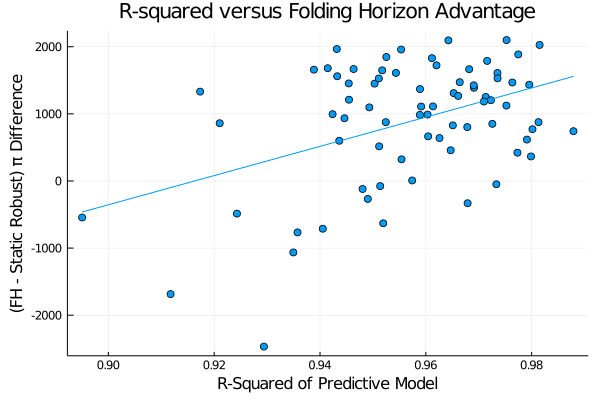

In [287]:
scatter(rsq_list , prof_difference, title = "R-squared versus Folding Horizon Advantage" ,label="",
xlabel="R-Squared of Predictive Model", ylabel="(FH - Static Robust) π Difference",smooth=true)

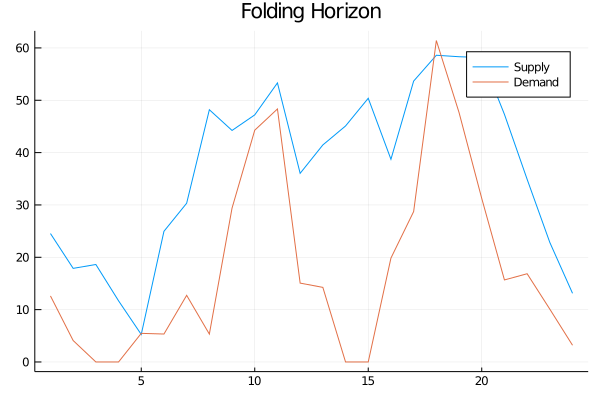

In [286]:
plot(s_fh, label="Supply", title = "Folding Horizon")
plot!(d_fh, label="Demand")